In [1]:
# Classic data science libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import cv2
import PIL
import os
from sklearn.model_selection import train_test_split

# libaries
from keras import layers, models
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Conv2D, BatchNormalization,MaxPooling2D, GlobalAveragePooling2D
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from keras import optimizers
from keras import Model
from keras.applications import MobileNetV2, VGG19, VGG16

In [2]:
# load dataset from kaggle

# from google.colab import files
# files.upload()
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle datasets download -d gpiosenka/100-bird-species
# ! unzip 100-bird-species.zip -d birds

In [3]:
class CONFIG():
  # files & directories
  MAIN_PATH = './birds'
  CSV_FILE = 'birds.csv'
  # variables
  IMAGE_SIZE = (224, 224)
  INPUT_SHAPE = (*IMAGE_SIZE, 3)
  NUM_CLASSES = 100
  BATCH_SIZE = 64
  EPOCHS = 5

In [4]:
dataset = pd.read_csv(os.path.join(CONFIG.MAIN_PATH, CONFIG.CSV_FILE))
dataset = dataset[dataset['class id'].map(lambda x: x in range(CONFIG.NUM_CLASSES))]
dataset['filepaths'] = dataset['filepaths'].map(lambda x: os.path.join(CONFIG.MAIN_PATH, x))
dataset

,class id,filepaths,labels,data set,scientific name
0,0,./birds/train/ABBOTTS BABBLER/001.jpg,ABBOTTS BABBLER,train,Malacocincla abbotti
1,0,./birds/train/ABBOTTS BABBLER/002.jpg,ABBOTTS BABBLER,train,Malacocincla abbotti
2,0,./birds/train/ABBOTTS BABBLER/003.jpg,ABBOTTS BABBLER,train,Malacocincla abbotti
3,0,./birds/train/ABBOTTS BABBLER/004.jpg,ABBOTTS BABBLER,train,Malacocincla abbotti
4,0,./birds/train/ABBOTTS BABBLER/005.jpg,ABBOTTS BABBLER,train,Malacocincla abbotti
...,...,...,...,...,...
83080,99,./birds/valid/BOBOLINK/1.jpg,BOBOLINK,valid,Dolichonyx oryzivorus
83081,99,./birds/valid/BOBOLINK/2.jpg,BOBOLINK,valid,Dolichonyx oryzivorus
83082,99,./birds/valid/BOBOLINK/3.jpg,BOBOLINK,valid,Dolichonyx oryzivorus
83083,99,./birds/valid/BOBOLINK/4.jpg,BOBOLINK,valid,Dolichonyx oryzivorus


In [5]:
# get train, test and valid sets
df_trainset = dataset[dataset['data set'] == 'train'][['class id', 'filepaths', 'labels']]
df_validset = dataset[dataset['data set'] == 'valid'][['class id', 'filepaths', 'labels']]
df_testset = dataset[dataset['data set'] == 'test'][['class id', 'filepaths', 'labels']]

# print shapes
print('Trainset shape:', df_trainset.shape)
print('Validset shape:', df_validset.shape)
print('Testset shape:', df_testset.shape)

Trainset shape: (15672, 3)
Validset shape: (500, 3)
Testset shape: (500, 3)


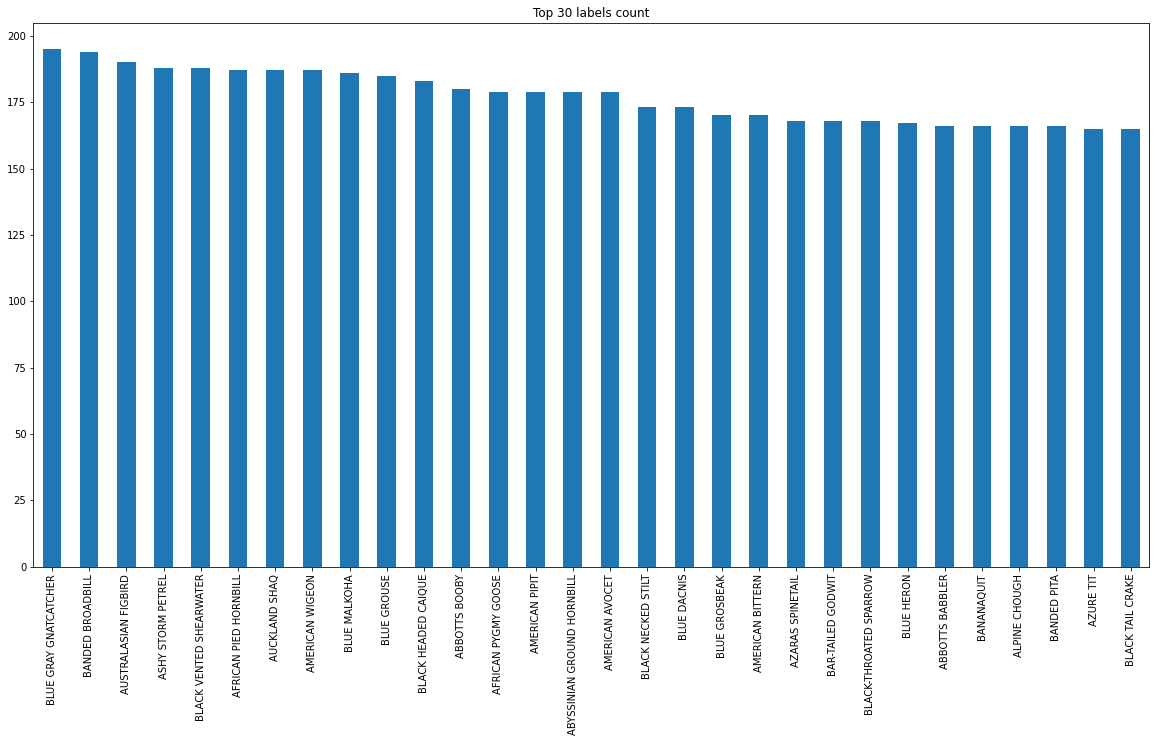

In [6]:
df_trainset['labels'].value_counts()[:30].plot(kind='bar', figsize=(20,10), title='Top 30 labels count')
plt.show()

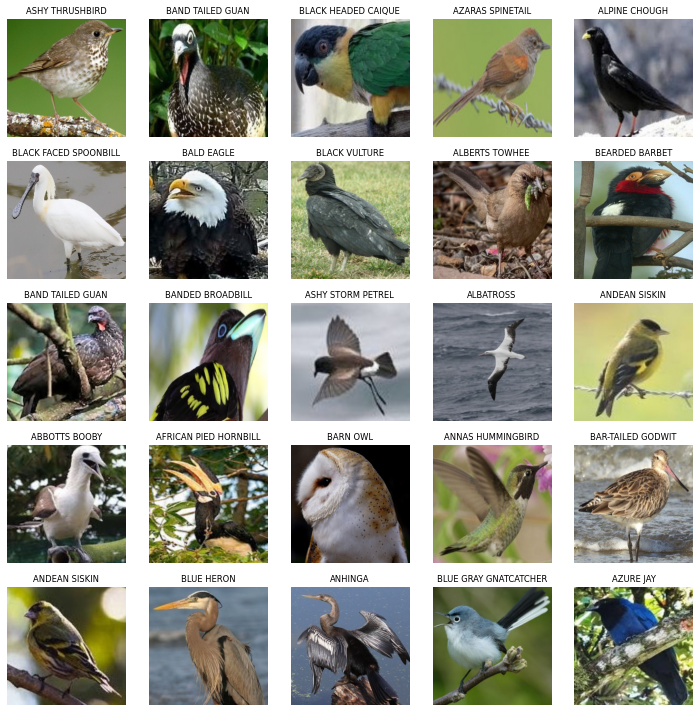

In [7]:
random_index = np.random.randint(0, len(df_trainset), 25)
fig, axes = plt.subplots(nrows=5, ncols=5,figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_trainset.filepaths[random_index[i]]))
    ax.set_title(df_trainset.labels[random_index[i]], fontsize='small')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [8]:
image_generator = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

In [9]:
# Split the data into three categories
train_images = image_generator.flow_from_dataframe(
    dataframe=df_trainset,
    x_col='filepaths',
    y_col='labels',
    target_size=CONFIG.IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True,
    seed=1,
    subset='training'
)

# Split the data into three categories
test_images = image_generator.flow_from_dataframe(
    dataframe=df_testset,
    x_col='filepaths',
    y_col='labels',
    target_size=CONFIG.IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True,
    seed=1,
    subset='training'
)

# Split the data into three categories
valid_images = image_generator.flow_from_dataframe(
    dataframe=df_validset,
    x_col='filepaths',
    y_col='labels',
    target_size=CONFIG.IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True,
    seed=1,
    subset='training'
)

Found 15672 validated image filenames belonging to 100 classes.
Found 500 validated image filenames belonging to 100 classes.
Found 500 validated image filenames belonging to 100 classes.


In [10]:
# Resize Layer
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(*CONFIG.IMAGE_SIZE),
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
])

In [31]:
base_model = VGG16(
    input_shape=CONFIG.INPUT_SHAPE,
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

base_model.trainable=False

In [32]:
for layer in base_model.layers[-5:]:
  layer.trainable = True

In [43]:
for layer in base_model.layers:
  print(layer.trainable, layer)

False <keras.engine.input_layer.InputLayer object at 0x7fe7ea22a130>
False <keras.layers.convolutional.conv2d.Conv2D object at 0x7fe7ec23ad00>
False <keras.layers.convolutional.conv2d.Conv2D object at 0x7fe7e4198f40>
False <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7fe7ea281310>
False <keras.layers.convolutional.conv2d.Conv2D object at 0x7fe7ebeabb20>
False <keras.layers.convolutional.conv2d.Conv2D object at 0x7fe7ebf83640>
False <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7fe7ea225ca0>
False <keras.layers.convolutional.conv2d.Conv2D object at 0x7fe7ea225bb0>
False <keras.layers.convolutional.conv2d.Conv2D object at 0x7fe7a80ae970>
False <keras.layers.convolutional.conv2d.Conv2D object at 0x7fe7ec169b80>
False <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7fe7a80ae7c0>
False <keras.layers.convolutional.conv2d.Conv2D object at 0x7fe7a80aee20>
False <keras.layers.convolutional.conv2d.Conv2D object at 0x7fe7a80b52e0>
False <keras.layers.co

In [34]:
inputs = base_model.input
x = resize_and_rescale(inputs)
x = Dense(256, activation='relu')(base_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(CONFIG.NUM_CLASSES, activation='softmax')(x)

model =  Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [44]:
# ! pip install tensorflow_addons
import tensorflow_addons as tfa
optimizers = [
    tf.keras.optimizers.Adam(learning_rate=1e-5),
    tf.keras.optimizers.Adam(learning_rate=1e-3)
]

optimizers_and_layers = [(optimizers[1], model.layers[-5:]), (optimizers[0], model.layers[-10:-5])]
optimizer = tfa.optimizers.MultiOptimizer(optimizers_and_layers)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [45]:
history = model.fit(
    train_images,
    validation_data=valid_images,
    epochs=CONFIG.EPOCHS - 2, # 8
)

Epoch 1/3
  7/490 [..............................] - ETA: 1:30 - loss: 0.1586 - accuracy: 0.9598

KeyboardInterrupt: ignored

In [41]:
results = model.evaluate(test_images)
print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

16/16 [==============================] - 2s 132ms/step - loss: 0.2059 - accuracy: 0.9380
Test Loss: 0.20594
Test Accuracy: 93.80%


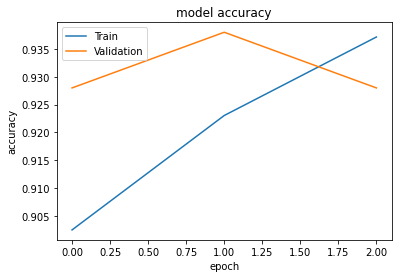

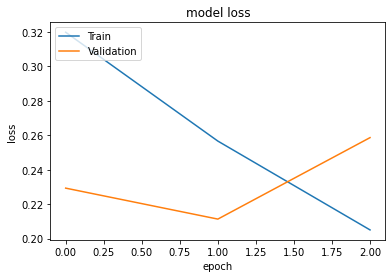

In [42]:
def plot_loss_accuracy_curves(history):
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show();
    
plot_loss_accuracy_curves(history)